In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential, Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.metrics import precision_score, f1_score, roc_auc_score, accuracy_score, recall_score
from sklearn.svm import LinearSVC
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer

import requests
import io

from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
df_short = pd.read_csv("https://raw.githubusercontent.com/bocsardigergely/bachelor-thesis/main/data/processed/processed_short.csv")
df_medium = pd.read_csv("https://raw.githubusercontent.com/bocsardigergely/bachelor-thesis/main/data/processed/processed_medium.csv")
df_dank = pd.read_csv("https://raw.githubusercontent.com/bocsardigergely/bachelor-thesis/main/data/processed/processed_dank.csv")
df_joint = pd.concat([df_short, df_medium, df_dank])
df_joint = df_joint.reset_index(drop=True)
df_train = df_joint.sample(frac=1).reset_index(drop=True)
vectorizer = TextVectorization(max_tokens=20000)
es = EarlyStopping(monitor='val_loss', patience=4)

vectorizer.adapt(np.asarray(df_train["text"]))

In [3]:
def build_cnn():
    response = requests.get('https://raw.githubusercontent.com/bocsardigergely/bachelor-thesis/main/universal.npy')
    init_matrix = np.load(io.BytesIO(response.content)) 
    submodels = []
    for kw in (3, 4, 5):    # kernel sizes
        submodel = Sequential()
        submodel.add(Embedding(
        20002,
        100,
        embeddings_initializer=keras.initializers.Constant(init_matrix),
        trainable=False,))
        submodel.add(Conv1D(100,    
                            kw,
                            padding='valid',
                            activation='relu',
                            strides=1, kernel_constraint=max_norm(5.397124926498551)
                             ))
        submodel.add(GlobalMaxPooling1D())
        submodels.append(submodel)

    submodel1 = submodels[0]
    submodel2 = submodels[1]
    submodel3 = submodels[2]

    x = add([submodel1.output, submodel2.output, submodel3.output])
    
    big_model = Sequential()
    big_model.add(Dropout(0.09225974322037533))
    big_model.add(Dense(25))
    big_model.add(Dropout(0.20942239619394942))
    big_model.add(Activation('relu'))
    big_model.add(Dense(1))
    big_model.add(Activation('sigmoid'))

    big_model_output = big_model(x)

    model = Model([submodel1.input, submodel2.input, submodel3.input], big_model_output)

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])  

    return model

In [4]:
def build_rnn():

    response = requests.get('https://raw.githubusercontent.com/bocsardigergely/bachelor-thesis/main/universal.npy')
    init_matrix = np.load(io.BytesIO(response.content))
    model = Sequential()
    model.add(Embedding(
      20002,
      100,
      embeddings_initializer=keras.initializers.Constant(init_matrix),
      trainable=False
  ))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.4143619965361732))
    model.add(Bidirectional(LSTM(1, return_sequences=False)))
    model.add(Dropout(0.09225974322037533))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.20942239619394942))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    

    return model

In [5]:
def train_svm(df):
    tfidf = TfidfVectorizer()
    name =[x for x in globals() if globals()[x] is df][0]
    #creating the desired vectors
    text = df['text']
    y = df["label"]
    text_train, text_test, y_train, y_test = train_test_split(
    text, y, test_size=0.33, random_state=42)
    X_train = tfidf.fit_transform(text_train.astype('U').values)
    X_test = tfidf.transform(text_test.astype('U').values)
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred_bool = svm.predict(X_test)

    fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred_bool)
    return fpr, tpr


In [6]:
def train_model(df, build_func):
    #creating the desired vectors
    text = np.asarray(df['text'])
    y = df["label"]
    text_train, text_test, y_train, y_test = train_test_split(
    text, y, test_size=0.2, random_state=42)

    X_train = vectorizer(text_train)
    X_test = vectorizer(text_test)

    model = build_func()

    model.fit([X_train, X_train, X_train],
                     y_train,
                     batch_size=32,
                     epochs=25,
                     validation_split=0.1,
                     callbacks=es,
                     verbose=0
                     )
    
    y_pred = model.predict([X_test, X_test, X_test])
    y_pred_bool = np.where(y_pred>0.5,1,0)

    fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred_bool)

    return fpr, tpr

In [20]:
fpr_cnn, tpr_cnn = train_model(df_dank, build_cnn)
fpr_lstm, tpr_lstm = train_model(df_dank, build_rnn)
fpr_svm, tpr_svm = train_svm(df_dank)


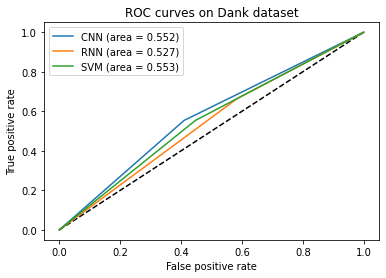

In [21]:
import matplotlib.pyplot as plt


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(0.552))
plt.plot(fpr_lstm, tpr_lstm, label='RNN (area = {:.3f})'.format(0.527))
plt.plot(fpr_svm, tpr_svm, label='SVM (area = {:.3f})'.format(0.553308823529412))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves on Dank dataset')
plt.legend(loc='best')
plt.savefig('dank_roc.png')
plt.show()

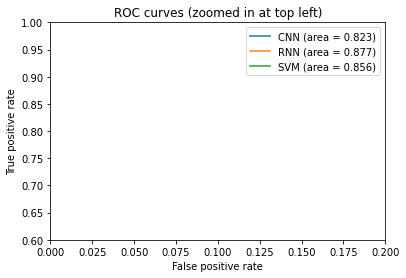

In [22]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(0.823))
plt.plot(fpr_lstm, tpr_lstm, label='RNN (area = {:.3f})'.format(0.877164446684936))
plt.plot(fpr_svm, tpr_svm, label='SVM (area = {:.3f})'.format(0.856176470588235))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('dank_roc_zoomed.png')

plt.show()